In [1]:
import pickle
from pathlib import Path
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import tensorflow as tf
import random

# Set the seed for Python's random module
random.seed(52)

# Set the seed for NumPy (used for matrix operations and other mathematical computations)
np.random.seed(52)

# Set the seed for TensorFlow (used for neural network training)
tf.random.set_seed(52)

In [2]:
column_names = ['id', 'classifier']
labels = pd.read_csv(r'C:\Users\wilke\Documents\ISL\IMPACT\Mars Classification\msl-labeled-data-set-v2.1\labels.txt', delimiter=' ', names=column_names, header=0, index_col=0)
print(labels['classifier'].value_counts())
y = labels.classifier.values

classifier
3     831
4     793
2     273
7     171
14    135
11    114
8      96
13     74
10     68
6      59
16     56
15     46
1      45
17     32
12     28
9      18
18     13
0      10
5       8
Name: count, dtype: int64


Example image has shape:  (227, 227, 3)
RGB values for the top left pixel are: [163  26   8]


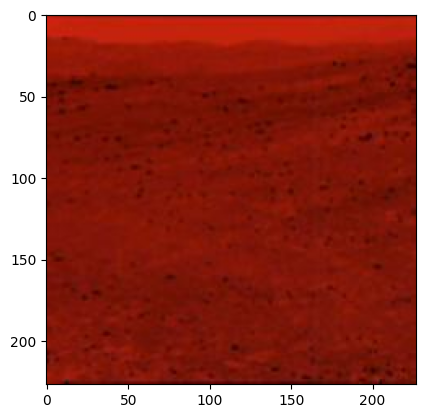

In [3]:
example_image = io.imread(r'C:\Users\wilke\Documents\ISL\IMPACT\Mars Classification\msl-labeled-data-set-v2.1\images\{}'.format(labels.index[0]))
plt.imshow(example_image)
print('Example image has shape: ', example_image.shape)
print('RGB values for the top left pixel are:', example_image[0, 0, :])

In [4]:
image_list = []

for i in labels.index:
    img = io.imread(r'C:\Users\wilke\Documents\ISL\IMPACT\Mars Classification\msl-labeled-data-set-v2.1\images\{}'.format(i)).astype(np.float64)
    image_list.append(img)
X = np.array(image_list)
print(X.shape)

(2870, 227, 227, 3)


In [5]:
x_interim, x_eval, y_interim, y_eval = train_test_split(X, y, test_size=0.2, random_state=52)
x_train, x_test, y_train, y_test = train_test_split(x_interim, y_interim, test_size=0.4, random_state=52)

from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=19)
y_test = to_categorical(y_test, num_classes=19)
y_eval = to_categorical(y_eval, num_classes=19)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'x_train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (1377, 227, 227, 3)
1377 x_train samples
919 test samples
574 eval samples


In [6]:
x_train = x_train / 255.0
x_eval = x_eval / 255.0
x_test = x_test / 255.0

In [7]:
num_classes = 19
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(0.00001), 
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history = model.fit(x_train, y_train, 
          epochs=50,  # Increase number of epochs to 20
          verbose=1, 
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])  # Add early stopping callback

# Evaluate the model
eval_loss, eval_acc = model.evaluate(x_eval, y_eval)
print(f"Eval loss: {eval_loss}, Eval accuracy: {eval_acc}")

Epoch 1/50
44/44 [==============================] - 189s 4s/step - loss: 2.4122 - accuracy: 0.2614 - val_loss: 2.2088 - val_accuracy: 0.2655
Epoch 2/50
44/44 [==============================] - 103s 2s/step - loss: 2.3060 - accuracy: 0.2774 - val_loss: 2.1758 - val_accuracy: 0.3003
Epoch 3/50
44/44 [==============================] - 101s 2s/step - loss: 2.2722 - accuracy: 0.2985 - val_loss: 2.1524 - val_accuracy: 0.3014
Epoch 4/50
44/44 [==============================] - 103s 2s/step - loss: 2.2593 - accuracy: 0.3065 - val_loss: 2.1448 - val_accuracy: 0.3025
Epoch 5/50
44/44 [==============================] - 105s 2s/step - loss: 2.2374 - accuracy: 0.2999 - val_loss: 2.1089 - val_accuracy: 0.3090
Epoch 6/50
44/44 [==============================] - 109s 2s/step - loss: 2.1978 - accuracy: 0.3094 - val_loss: 2.0855 - val_accuracy: 0.3134
Epoch 7/50
44/44 [==============================] - 108s 2s/step - loss: 2.1755 - accuracy: 0.3217 - val_loss: 2.0621 - val_accuracy: 0.3112
Epoch 8/50
44

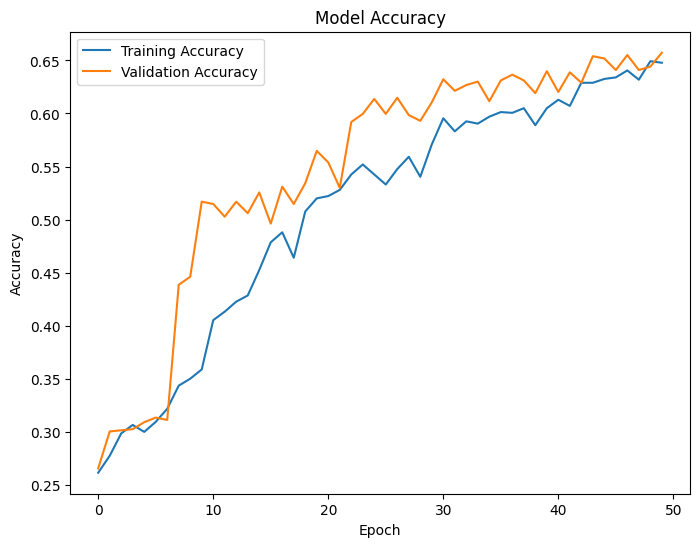

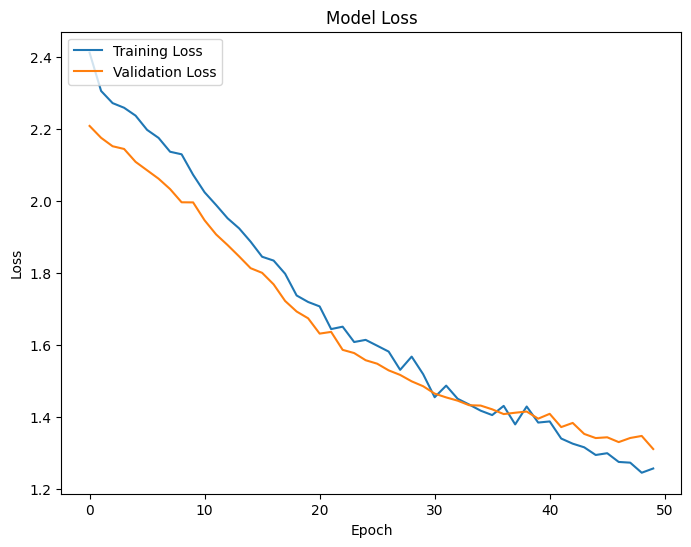

In [9]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

plt.figure(figsize=[8,6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [10]:
import pickle

with open('model_history_run2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [11]:
model.save('mars_classifier_model_run2.keras')
#load from tensorflow.keras.models import load_model
#model = load_model('mars_classifier_model.keras')